# ISIC 2024 - Skin Cancer Detection with 3D-TBP
## Using MobileNet


### Importing Libraries 🗃️

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import random 


### Data Analysis and Visulization 🔬

In [17]:
train_file = pd.read_csv("Aug_train.csv",low_memory=False)
train_file.head()

,isic_id,target
0,ISIC_7931446,0
1,ISIC_1968391,0
2,ISIC_0251481,0
3,ISIC_9678329,0
4,ISIC_5942580,0


In [18]:
train_file['target'].value_counts()

target
0    7860
1    7860
Name: count, dtype: int64

## Plotting Image 📈

In [19]:
image_dir = os.listdir('augment_pos')
print('No of Images we have -->',len(image_dir))

No of Images we have --> 15720


In [20]:
# taking 8 random positive and negative image
pos_img_file = random.sample(list(train_file.loc[train_file['target'] == 1]['isic_id']),8) 
print('Postive Image ID-->',pos_img_file)


neg_img_file = random.sample(list(train_file.loc[train_file['target'] == 0]['isic_id']),8) 
print('Negative Image ID-->',neg_img_file)

Postive Image ID--> ['aug_19_ISIC_0238218', 'aug_10_ISIC_5043386', 'aug_17_ISIC_6149388', 'aug_12_ISIC_2299573', 'aug_12_ISIC_3121355', 'aug_9_ISIC_9188287', 'aug_0_ISIC_0467830', 'aug_18_ISIC_9360322']
Negative Image ID--> ['ISIC_3658055', 'ISIC_9358274', 'ISIC_7414218', 'ISIC_4629921', 'ISIC_9671127', 'ISIC_4924552', 'ISIC_9688776', 'ISIC_0835076']


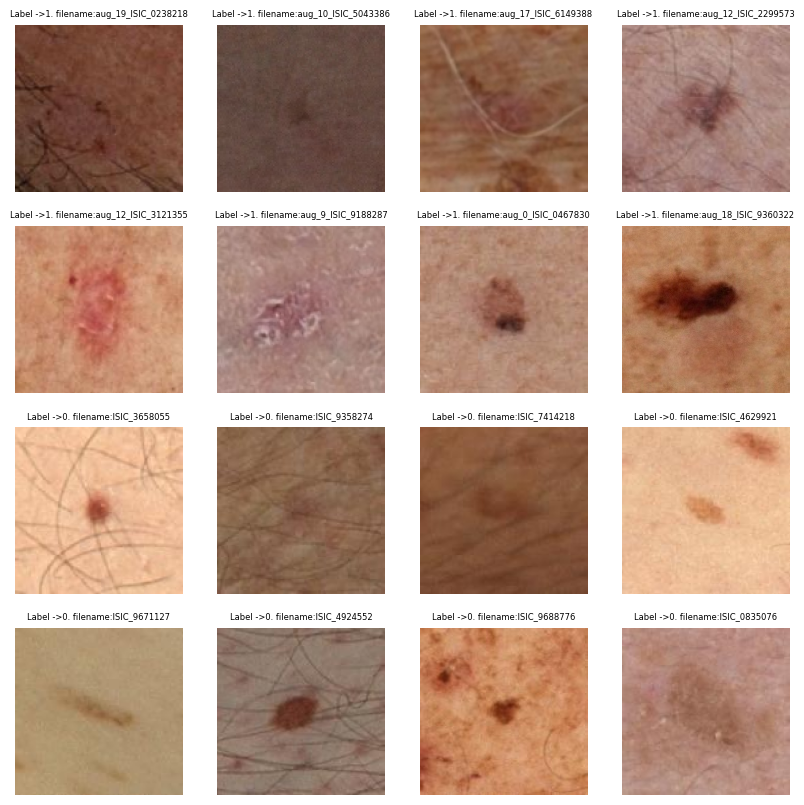

In [21]:
fig , axis = plt.subplots(nrows= 4 , ncols = 4 ,figsize=(10,10))

for ax , im , target in zip(axis.flatten(),pos_img_file+neg_img_file,[1]*8+[0]*8):
    img = Image.open('augment_pos/'+f'{im}.jpg')
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Label ->{target}. filename:{im}',fontsize= 6)


## Data Pre-Processing ⚖️

In [22]:
image_paths = list(train_file['isic_id'])
image_labels = list(train_file['target'])


In [23]:
print(image_labels[:5])
image_paths[:5]

[0, 0, 0, 0, 0]


['ISIC_7931446',
 'ISIC_1968391',
 'ISIC_0251481',
 'ISIC_9678329',
 'ISIC_5942580']

In [36]:
def load_and_preprocess_image(im_path, label):
    im_path = tf.strings.join(['augment_pos/', im_path, '.jpg'], separator='')
    image = tf.io.read_file(im_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [120, 120])
    image = image / 255.0
    return image, label

# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))

# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=len(image_paths), seed=42)

# Define the split ratio
validation_split = 0.2
dataset_size = len(image_paths)
validation_size = int(validation_split * dataset_size)
train_size = dataset_size - validation_size

# Split the dataset into training and validation sets
train_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size)


In [37]:
# Map the preprocessing function to both datasets
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch the datasets
batch_size = 5
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


In [38]:
len(train_dataset)

2516

## Building  Model 🧠 
### Using Transfer ResNEt18

In [39]:
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D,Flatten , Input, GlobalMaxPooling2D
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential

from tensorflow import keras
from tensorflow.keras.models import load_model
import tensorflow as tf


## Base of Efficentnet


In [40]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7
conv_base = EfficientNetB7(
    weights='imagenet',
    input_shape= (120,120,3),
    include_top= False
)

In [41]:
conv_base.trainable = True

In [42]:
for layer in conv_base.layers[:-10]:
    layer.trainable = False

In [43]:
for layer in conv_base.layers:
    print(layer.name,layer.trainable)

input_8 False
rescaling_4 False
normalization_6 False
rescaling_5 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block1c_dwconv False
block1c_bn False
block1c_activation False
block1c_se_squeeze False
block1c_se_reshape False
block1c_se_reduce False
block1c_se_expand False
block1c_se_excite False
block1c_project_conv False
block1c_project_bn False
block1c_drop False
block1c_add False
block1d_dwconv False
block1d_bn False
block1d_activation False
block1d_

In [44]:
inputs = Input(shape= (120,120,3)),
x = conv_base(inputs)

x = Flatten()(x)
x = Dense(64,activation = 'relu')(x)
x = layers.Normalization()(x)
x = Dense(128,activation = 'relu')(x)
x = layers.Normalization()(x)

#x = layers.Dropout(0.5)(x)
outputs =  Dense(1,activation = 'sigmoid')(x)


model = Model(inputs,outputs)



In [45]:
model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.RMSprop(learning_rate=(1e-5)),metrics=['acc'])


In [46]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 efficientnetb7 (Functional)  (None, 4, 4, 2560)       64097687  
                                                                 
 flatten_2 (Flatten)         (None, 40960)             0         
                                                                 
 dense_6 (Dense)             (None, 64)                2621504   
                                                                 
 normalization_7 (Normalizat  (None, 64)               129       
 ion)                                                            
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                           

In [47]:
history = model.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs = 20,
                    validation_steps = 20)

Epoch 1/20
2516/2516 [==============================] - 84s 28ms/step - loss: 0.6985 - acc: 0.5082 - val_loss: 0.6928 - val_acc: 0.5100
Epoch 2/20
2516/2516 [==============================] - 68s 27ms/step - loss: 0.6950 - acc: 0.5074 - val_loss: 0.6982 - val_acc: 0.4800
Epoch 3/20
2516/2516 [==============================] - 85s 34ms/step - loss: 0.6947 - acc: 0.5053 - val_loss: 0.6961 - val_acc: 0.5000
Epoch 4/20
2516/2516 [==============================] - 68s 27ms/step - loss: 0.6944 - acc: 0.4980 - val_loss: 0.6943 - val_acc: 0.4900
Epoch 5/20
2516/2516 [==============================] - 69s 27ms/step - loss: 0.6944 - acc: 0.4984 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 6/20
2516/2516 [==============================] - 119s 47ms/step - loss: 0.6949 - acc: 0.5013 - val_loss: 0.6927 - val_acc: 0.5000
Epoch 7/20
1813/2516 [====================>.........] - ETA: 1:11 - loss: 0.6951 - acc: 0.5014

: 

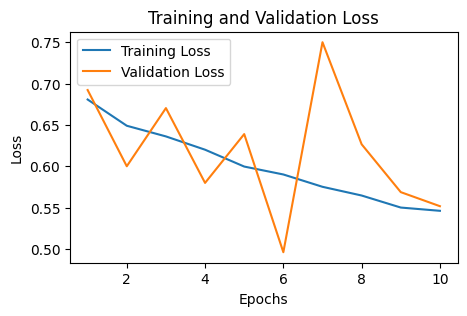

In [ ]:

# Extract accuracy and validation accuracy
accuracy = history.history['loss']
val_accuracy = history.history['val_loss']

# Extract number of epochs
epochs = range(1, len(accuracy) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(5, 3))
plt.plot(epochs, accuracy, label='Training Loss')
plt.plot(epochs, val_accuracy, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


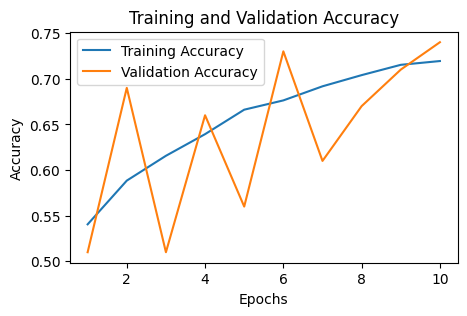

In [ ]:
# Extract accuracy and validation accuracy
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

# Extract number of epochs
epochs = range(1, len(accuracy) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(5, 3))
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
ta = history.history['acc'][-1] * 100
va = history.history['val_acc'][-1] * 100
print(f"Training Accuracy is {ta:.3f}%")
print(f'Validation Accuracy is {va:.3f}%')

Training Accuracy is 71.939%
Validation Accuracy is 74.000%


In [ ]:
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
import cv2
import io

# Load the HDF5 file
file_path = 'C:/Users/M_ros/Downloads/isic-2024-challenge/test-image.hdf5'  # Replace with your HDF5 file path
image_ids = []
predictions = []
images = []

# Function to preprocess images
def preprocess_image(image):
    img_resized = cv2.resize(image, (224, 224))
    img_resized = img_resized.astype('float32') / 255.0
    return img_resized

with h5py.File(file_path, 'r') as hdf:
    # Get the number of test images
    num_test_images = len(hdf.keys())
    
    # Set batch size based on the number of test images
    if num_test_images <= 3:
        batch_size = 3
    else:
        batch_size = 150
    
    # Access each dataset and process the data
    for key in hdf.keys():
        binary_data = hdf[key][...]
        image_ids.append(key)
        
        # Convert binary data to image
        image = Image.open(io.BytesIO(binary_data))
        image = np.array(image)  # Convert PIL Image to numpy array
        preprocessed_image = preprocess_image(image)
        images.append(preprocessed_image)
        
        # If the batch size is reached, make predictions
        if len(images) == batch_size:
            images_np = np.array(images)
            batch_predictions = model.predict(images_np)
            predictions.extend([f'{pred[0]:.6f}' for pred in batch_predictions])
            images = []  # Reset the list for the next batch

    # Process remaining images if any
    if images:
        images_np = np.array(images)
        batch_predictions = model.predict(images_np)
        predictions.extend([f'{pred[0]:.6f}' for pred in batch_predictions])

# Print predictions
for image_id, prediction in zip(image_ids, predictions):
    print(f"Prediction for image {image_id}: {prediction}")


1/1 [==============================] - 1s 663ms/step
Prediction for image ISIC_0015657: 0.674035
Prediction for image ISIC_0015729: 0.328748
Prediction for image ISIC_0015740: 0.687082


In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import random

# Load the dataset
train_file = pd.read_csv("train-metadata.csv", low_memory=False)

# Check the number of images for each class
print("No of Target in the Dataset")
print(train_file['target'].value_counts())

# Define the image directory
image_dir = os.listdir('train-image/image')
print('No of Images we have -->', len(image_dir))

# Paths and labels
images_paths = []
images_labels = []

# Number of positive and negative samples
n_pos = train_file['target'].value_counts()[1]  # Number of positive images
n_neg = train_file['target'].value_counts()[0]  # Number of negative images

# Downsample the negative images to match the number of positive images
neg_img_paths = random.sample(list(train_file.loc[train_file['target'] == 0]['isic_id']), n_pos)

# Upsample the positive images to match the number of negative images
pos_img_paths = random.choices(list(train_file.loc[train_file['target'] == 1]['isic_id']), k=n_neg)

# Combine the paths
balanced_img_paths = neg_img_paths + pos_img_paths
balanced_labels = [0] * len(neg_img_paths) + [1] * len(pos_img_paths)

# Shuffle the combined data
combined = list(zip(balanced_img_paths, balanced_labels))
random.shuffle(combined)
balanced_img_paths, balanced_labels = zip(*combined)

# Now you have balanced_img_paths and balanced_labels with equal distribution of classes
print("Balanced dataset size:", len(balanced_img_paths))
print("Distribution in balanced dataset:")
print(pd.Series(balanced_labels).value_counts())


No of Target in the Dataset
target
0    400666
1       393
Name: count, dtype: int64
No of Images we have --> 401059
Balanced dataset size: 401059
Distribution in balanced dataset:
1    400666
0       393
Name: count, dtype: int64


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Load the dataset
train_file = pd.read_csv("train-metadata.csv", low_memory=False)

# Calculate the class distribution
class_counts = train_file['target'].value_counts()

# Calculate the total number of samples
total_samples = len(train_file)

# Calculate the class weights
class_weights = { 
    0: total_samples / (2 * class_counts[0]),  # weight for class 0
    1: total_samples / (2 * class_counts[1])   # weight for class 1
}

# Print class weights
print("Class Weights:", class_weights)



Class Weights: {0: 0.5004904334283418, 1: 510.25318066157763}


In [9]:
from sklearn.utils.class_weight import compute_class_weight

# Assume df is your DataFrame and 'target' is the column with class labels
class_weights = compute_class_weight('balanced', classes=np.unique(train_file['target']), y=train_file['target'])
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 0.5004904334283418, 1: 510.25318066157763}
